# EDA Notebook
In this notebook we conduct exploratory data analysis to our dataset to better understand the nature of our data and insights for machine learning efforts.

### Pie Chart of Countries

country
US    345443
GB     49803
CA     43843
AU     34886
DE     12327
       ...  
TD         1
NE         1
GN         1
AS         1
SH         1
Name: count, Length: 222, dtype: int64


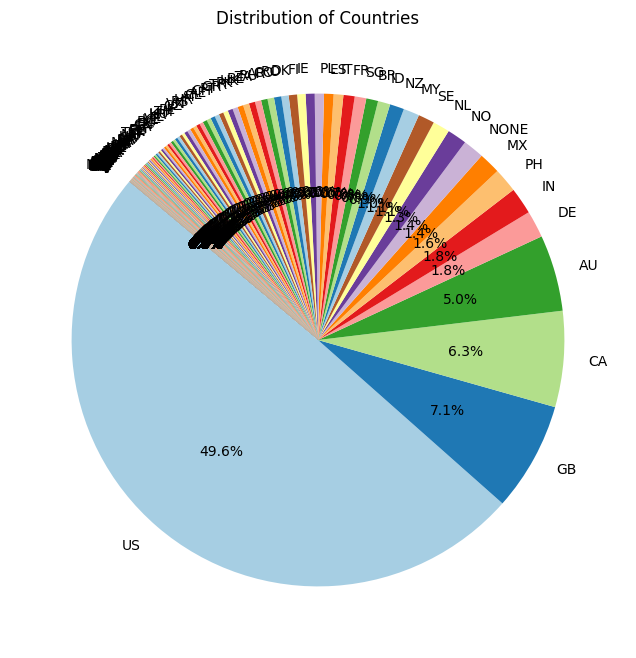

In [ ]:
country_counts = processed_data["country"].value_counts()
print(country_counts)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Countries")
plt.show()

In [ ]:
df_converted

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,4.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,5.0,1.0,5.0,1.0,3.0,1.0,5.0,4.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015334,4.0,1.0,4.0,2.0,4.0,3.0,3.0,2.0,3.0,2.0,...,3.0,3.0,5.0,3.0,4.0,2.0,5.0,2.0,3.0,4.0
1015335,5.0,1.0,5.0,2.0,4.0,2.0,3.0,1.0,5.0,1.0,...,4.0,1.0,4.0,2.0,3.0,2.0,5.0,3.0,4.0,4.0
1015337,4.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,...,4.0,1.0,5.0,1.0,5.0,1.0,3.0,4.0,5.0,4.0
1015339,2.0,4.0,3.0,4.0,2.0,2.0,1.0,4.0,2.0,4.0,...,5.0,2.0,4.0,2.0,3.0,2.0,4.0,5.0,5.0,3.0


### Correlation Heatmap

<Axes: >

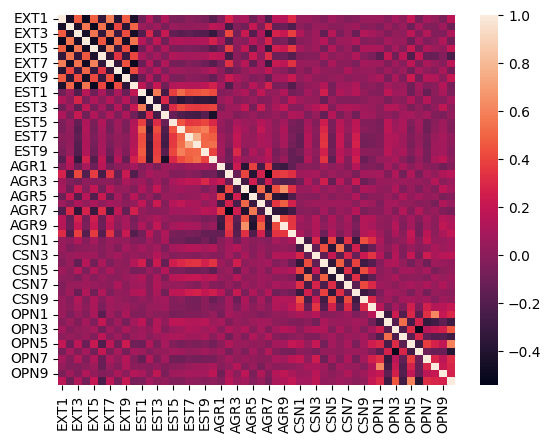

In [ ]:
import seaborn as sns
sns.heatmap(df_converted.corr())